<a href="https://colab.research.google.com/github/masteroojway/saidl_project/blob/main/Core_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
import numpy as np
import torch
import torch.nn as nn #for model layers
import torch.nn.functional as F  # Import functional API

import torchvision.ops as ops
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
#Data preperation by modifying CIFAR-10
def data_prep():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle= False)

    # Extract labels as a tensor
    train_labels = torch.tensor(train_dataset.targets)
    test_labels = torch.tensor(test_dataset.targets)
    return train_loader, test_loader, train_labels, test_labels,train_dataset

In [ ]:
def add_symmetric_noise(labels, noise_rate=0.4):
    num_classes = 10
    noisy_labels = labels.clone()

    for class_id in range(num_classes):
        class_indices = (labels == class_id).nonzero(as_tuple=True)[0]
        num_class_samples = len(class_indices)

        # Number of samples to flip
        n = int(num_class_samples * noise_rate)

        # Randomly choose 'n' indices to flip
        noisy_indices = np.random.choice(class_indices.numpy(), n, replace=False)

        for idx in noisy_indices:
            # Flip label to a random class, excluding the current class
            new_label = np.random.choice([i for i in range(num_classes) if i != class_id])
            noisy_labels[idx] = new_label

    return noisy_labels

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3 → 16 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16 → 32 channels

        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Reduced FC layer
        self.fc2 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  #downsample (32x32 - 16x16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  #downsample (16x16 - 8x8)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        probs_with_target = probs[torch.arange(len(probs)), targets]  # Extract true class probabilities
        focal_weight = (1 - probs_with_target) ** self.gamma  # Compute focal weight
        loss = -focal_weight * torch.log(probs_with_target + 1e-9)  # Apply Focal Loss formula
        return loss.mean()


In [ ]:
class ReverseCrossEntropy(nn.Module):
    def __init__(self, num_classes = 10, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Convert logits to probabilities
        # Convert targets to one-hot encoding
        target_onehot = F.one_hot(target, num_classes=self.num_classes).float()
        # Reverse CE: target * log(pred)
        rce_loss = -torch.sum(target_onehot * torch.log(pred + 1e-10)) / pred.size(0)
        return self.scale * rce_loss

In [ ]:
class NormalizedCrossEntropy(nn.Module):
    def __init__(self, tuning_parameter=0.7):
        super(NormalizedCrossEntropy, self).__init__()
        self.tuning_parameter = tuning_parameter

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        probs_with_target = probs[torch.arange(len(probs)), targets]  # Select true class probabilities
        loss = (1 - probs_with_target**self.tuning_parameter) / self.tuning_parameter  # Apply NCE formula
        return loss.mean()

In [ ]:
class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, tuning_parameter=0.7):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma  # Focusing parameter
        self.tuning_parameter = tuning_parameter  # Normalization parameter

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        probs_with_target = probs[torch.arange(len(probs)), targets]  # Select true class probabilities
        probs_with_target = probs_with_target.clamp(min=1e-6, max=1.0)  # Avoid zero probabilities
        loss = ((1 - probs_with_target**self.tuning_parameter) / self.tuning_parameter)*((1 - probs_with_target) ** self.gamma)  # Normalization term
        return loss.mean()

In [ ]:
train_loader, test_loader,train_labels, test_labels,train_dataset = data_prep()
noisy_labels = add_symmetric_noise(train_labels, noise_rate=0.8) #adjust noise rate here
noisy_train_dataset = [(data, noisy_label) for (data, _), noisy_label in zip(train_dataset, noisy_labels)]
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=1000, shuffle=True)
model = CNN() #NCE
model1 = CNN() #NFL
model2 = CNN() #NCE + RCE
model3 = CNN() #CE
model4 = CNN() #FL
#adjust tuning parameter and gamma from here

loss1 = NormalizedCrossEntropy(tuning_parameter=0.7)
loss2 = NormalizedFocalLoss(gamma=2.0, tuning_parameter=0.7)
loss3 = nn.CrossEntropyLoss()
loss4 = FocalLoss(gamma=2.0)
loss5 = ReverseCrossEntropy()
# standard Adam optimizer for all models
optimizer = optim.Adam(model.parameters(), lr=0.003) #NCE
optimizer1 = optim.Adam(model1.parameters(), lr=0.003) #NFL
optimizer2 = optim.Adam(model2.parameters(), lr=0.003) #NCE + RCE
optimizer3 = optim.Adam(model3.parameters(), lr=0.003) #CE
optimizer4 = optim.Adam(model4.parameters(), lr=0.003) #FL


In [ ]:
#vanilla Cross entropy loss function
for epochs in range(10):
  model3.train()
  total_loss = 0
  for batch_idx, (inputs, target) in enumerate(noisy_train_loader):
    optimizer3.zero_grad()
    output = model3(inputs)
    loss = loss3(output, target)
    loss.backward()  # Corrected from 'backwards' to 'backward'
    optimizer3.step()
    total_loss += loss.item()
  print(f"Epoch [{epochs+1}/10], Loss: {total_loss/len(noisy_train_loader):.4f}")

Epoch [1/10], Loss: 2.3026
Epoch [2/10], Loss: 2.3011
Epoch [3/10], Loss: 2.2993
Epoch [4/10], Loss: 2.2982
Epoch [5/10], Loss: 2.2969
Epoch [6/10], Loss: 2.2954
Epoch [7/10], Loss: 2.2924
Epoch [8/10], Loss: 2.2891
Epoch [9/10], Loss: 2.2857
Epoch [10/10], Loss: 2.2813


In [ ]:
#vanilla focal loss function
for epochs in range(10):
  model4.train()
  total_loss = 0
  for batch_idx, (inputs, target) in enumerate(noisy_train_loader):
    optimizer4.zero_grad()
    output = model4(inputs)
    loss_4 = loss4(output, target)
    loss_4.backward()
    optimizer4.step()
    total_loss += loss_4.item()
  print(f"Epoch [{epochs+1}/10], Loss: {total_loss/len(noisy_train_loader):.4f}")


Epoch [1/10], Loss: 1.8658
Epoch [2/10], Loss: 1.8621
Epoch [3/10], Loss: 1.8594
Epoch [4/10], Loss: 1.8570
Epoch [5/10], Loss: 1.8546
Epoch [6/10], Loss: 1.8513
Epoch [7/10], Loss: 1.8477
Epoch [8/10], Loss: 1.8435
Epoch [9/10], Loss: 1.8361
Epoch [10/10], Loss: 1.8263


In [ ]:
#normalised Cross Entropy loss Function
for epochs in range(10):
  model.train()
  total_loss = 0
  for batch_idx, (inputs, target) in enumerate(noisy_train_loader):
    optimizer.zero_grad()
    output = model(inputs)
    loss_1 = loss1(output, target)
    loss_1.backward()
    optimizer.step()
    total_loss += loss_1.item()
  print(f"Epoch [{epochs+1}/10], Loss: {total_loss/len(noisy_train_loader):.4f}")


Epoch [1/10], Loss: 1.1433
Epoch [2/10], Loss: 1.1416
Epoch [3/10], Loss: 1.1404
Epoch [4/10], Loss: 1.1382
Epoch [5/10], Loss: 1.1354
Epoch [6/10], Loss: 1.1328
Epoch [7/10], Loss: 1.1295
Epoch [8/10], Loss: 1.1254
Epoch [9/10], Loss: 1.1219
Epoch [10/10], Loss: 1.1162


In [ ]:
#Training Normalised Focal Loss Model
for epochs in range(10):
  model1.train()
  total_loss1 = 0
  for batch_idx, (inputs, target) in enumerate(noisy_train_loader):
    optimizer1.zero_grad()
    output1 = model1(inputs)
    loss_2 = loss2(output1, target)
    loss_2.backward()
    optimizer1.step()
    total_loss1 += loss_2.item()
  print(f"Epoch [{epochs+1}/10], Loss: {total_loss1/len(noisy_train_loader):.4f}")

Epoch [1/10], Loss: 0.9266
Epoch [2/10], Loss: 0.9249
Epoch [3/10], Loss: 0.9232
Epoch [4/10], Loss: 0.9219
Epoch [5/10], Loss: 0.9206
Epoch [6/10], Loss: 0.9194
Epoch [7/10], Loss: 0.9179
Epoch [8/10], Loss: 0.9162
Epoch [9/10], Loss: 0.9145
Epoch [10/10], Loss: 0.9128


In [ ]:
for epochs in range(10):
  model2.train()
  total_loss = 0
  for batch_idx, (inputs, target) in enumerate(noisy_train_loader):
    optimizer2.zero_grad()
    output = model2(inputs)
    loss_APL = 0.1*loss1(output, target) + loss5(output, target)
    loss_APL.backward()
    optimizer2.step()
    total_loss += loss_APL.item()
  print(f"Epoch [{epochs+1}/10], Loss: {total_loss/len(noisy_train_loader):.4f}")

Epoch [1/10], Loss: 2.4173
Epoch [2/10], Loss: 2.4145
Epoch [3/10], Loss: 2.4128
Epoch [4/10], Loss: 2.4096
Epoch [5/10], Loss: 2.4070
Epoch [6/10], Loss: 2.4043
Epoch [7/10], Loss: 2.4003
Epoch [8/10], Loss: 2.3953
Epoch [9/10], Loss: 2.3900
Epoch [10/10], Loss: 2.3796


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total samples

    return correct / total


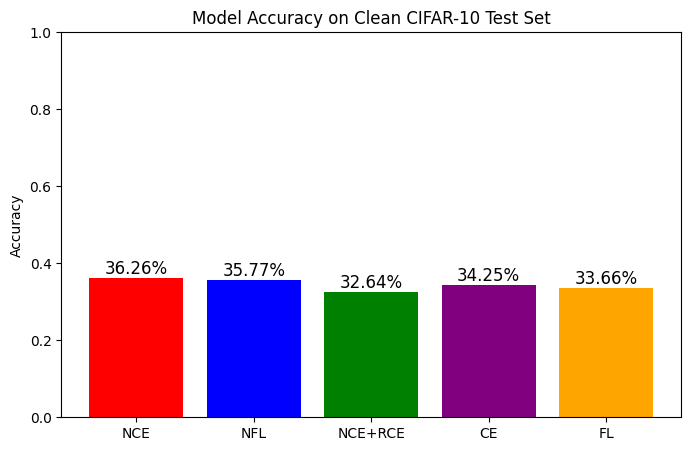

In [ ]:
model_names = ["NCE", "NFL", "NCE+RCE", "CE", "FL"]
models = [model, model1, model2, model3, model4]
accuracies = [evaluate_model(m, test_loader) for m in models]

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=["red", "blue", "green", "purple", "orange"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Clean CIFAR-10 Test Set")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2%}", ha='center', va='bottom', fontsize=12)

plt.show()


> Add blockquote

